# 🧠 Vision Transformer vs Quantum-Inspired Vision Transformer
This Colab notebook compares a small regular ViT and a simulated quantum-inspired ViT using PennyLane and PyTorch on a subset of CIFAR-10.

In [1]:
# 📦 Install required packages
!pip install -q pennylane torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [2]:
# 🔍 Import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import pennylane as qml
import numpy as np
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


## 📥 Load CIFAR-10 (small subset for fast training)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

# Use a subset for speed
train_subset = Subset(train_dataset, list(range(1000)))
test_subset = Subset(test_dataset, list(range(200)))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 87.7MB/s]


## ✅ Simple ViT (Tiny Custom Model)

In [4]:
class SimpleViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

## ⚛️ Quantum Layer for Quantum-Inspired ViT

In [5]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

In [6]:
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (1, n_qubits)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.q_layer(x)

## 🔗 Hybrid Quantum ViT

In [7]:
class HybridViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, n_qubits)
        self.q_layer = QuantumLayer()
        self.fc2 = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = self.q_layer(x)
        return self.fc2(x)

In [8]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy


In [9]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5

# Instantiate models
model_classic = SimpleViT().to(device)
model_quantum = HybridViT().to(device)

# Optimizers and loss
optimizer_classic = torch.optim.Adam(model_classic.parameters(), lr=0.001)
optimizer_quantum = torch.optim.Adam(model_quantum.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

classic_train_acc, quantum_train_acc = [], []
classic_test_acc, quantum_test_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    loss_c, acc_c = train(model_classic, train_loader, optimizer_classic, criterion, device)
    val_loss_c, val_acc_c = evaluate(model_classic, test_loader, criterion, device)

    loss_q, acc_q = train(model_quantum, train_loader, optimizer_quantum, criterion, device)
    val_loss_q, val_acc_q = evaluate(model_quantum, test_loader, criterion, device)

    print(f"Classic ViT - Train Acc: {acc_c:.2f}%, Test Acc: {val_acc_c:.2f}%")
    print(f"Quantum ViT - Train Acc: {acc_q:.2f}%, Test Acc: {val_acc_q:.2f}%\n")

    classic_train_acc.append(acc_c)
    quantum_train_acc.append(acc_q)
    classic_test_acc.append(val_acc_c)
    quantum_test_acc.append(val_acc_q)


Epoch 1/5
Classic ViT - Train Acc: 27.00%, Test Acc: 30.50%
Quantum ViT - Train Acc: 9.10%, Test Acc: 12.00%

Epoch 2/5
Classic ViT - Train Acc: 46.10%, Test Acc: 28.00%
Quantum ViT - Train Acc: 12.40%, Test Acc: 15.00%

Epoch 3/5
Classic ViT - Train Acc: 57.40%, Test Acc: 30.00%
Quantum ViT - Train Acc: 16.10%, Test Acc: 14.00%

Epoch 4/5
Classic ViT - Train Acc: 67.60%, Test Acc: 30.50%
Quantum ViT - Train Acc: 18.60%, Test Acc: 16.50%

Epoch 5/5
Classic ViT - Train Acc: 73.00%, Test Acc: 33.00%
Quantum ViT - Train Acc: 19.60%, Test Acc: 18.50%



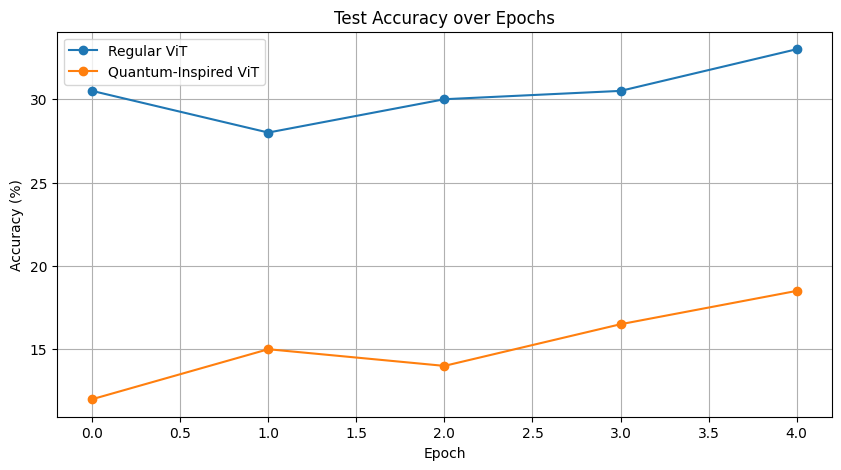

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(classic_test_acc, label='Regular ViT', marker='o')
plt.plot(quantum_test_acc, label='Quantum-Inspired ViT', marker='o')
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
